In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
path = r"C:\Users\User\Documents\Python Scripts\bangla_local_language_data - Sheet1 (1).csv"

In [4]:
df=pd.read_csv(path)
print(df)

                                         Modern Bangla  \
0                                  আমি আপনাকে ঘৃণা করি   
1                                  আমি তোমায় ভালোবাসি   
2                               আমি তোমার প্রেমে পড়েছি   
3                                           আমি দুঃখিত   
4                                      আমি খুবই দুঃখিত   
...                                                ...   
3468                          বেশি গর্ব সর্বনাশের কারণ   
3469  অতি পরিচিত লোক গুণী হলেও উপযুক্ত মর্যাদা পায় না   
3470               অসৎ উপায়ে অর্জিত ধন অকাজে নষ্ট হয়   
3471              খারাপ কিছু থাকার চেয়ে না থাকাই ভালো   
3472                      অপচয় করবে না এবং অভাব হবে না   

                     Sylheti  Total Needed  Total Translated  
0     আমি আপনারে বালা পাই না        3473.0             647.0  
1        আমি তোমারে বালা পাই           NaN               NaN  
2     আমি তোমার বালা পাইলিছি           NaN               NaN  
3            আমার বুল অইগেছে           NaN         

In [5]:
df=df.drop(["Total Needed", "Total Translated"], axis=1)

In [6]:
df=df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 647 entries, 0 to 3251
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Modern Bangla  647 non-null    object
 1   Sylheti        647 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [8]:
old_column_name = 'Modern Bangla'
new_column_name = 'Bangla'
df.rename(columns={'Modern Bangla': 'Bangla'}, inplace=True)

In [9]:
df['Bangla'] = df['Bangla'].astype(str)
df['Sylheti'] = df['Sylheti'].astype(str)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 647 entries, 0 to 3251
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Bangla   647 non-null    object
 1   Sylheti  647 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [11]:
# Define your input sequences (Sylheti sentences) and target sequences (Bangla translations)
X_train = df['Sylheti'].astype(str).tolist()
y_train = df['Bangla'].astype(str).tolist()

# Initialize a tokenizer with vocabulary size
vocab_size = 10000  # Vocabulary size
max_sequence_length = 50  # Maximum sequence length for padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')  # Vocabulary size and out-of-vocabulary token

# Fit tokenizer on combined input and target text
combined_texts = X_train + y_train  # Combine Sylheti and Bangla texts
tokenizer.fit_on_texts(combined_texts)

# Convert text to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
y_train_sequences = tokenizer.texts_to_sequences(y_train)

# Pad sequences to a maximum length
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
y_train_padded = pad_sequences(y_train_sequences, maxlen=max_sequence_length, padding='post')

In [12]:
# Define the LSTM model architecture
embedding_dim = 64
lstm_units = 128

# Encoder
encoder_inputs = Input(shape=(max_sequence_length,))
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Decoder
decoder_inputs = Input(shape=(max_sequence_length,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
decoder_dense = Dense(vocab_size, activation='softmax')
output = decoder_dense(decoder_outputs)

In [13]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model and capture the training history
history = model.fit([X_train_padded, X_train_padded], y_train_padded, epochs=20, batch_size=32, validation_split=0.2)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 64)    │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 50, 64)    │    640,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │     98,816 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50, 128), │     98,816 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50, 10000) │  1,290,000 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,767,632 (10.56 MB)

 Trainable params: 2,767,632 (10.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.7228 - loss: 8.7427 - val_accuracy: 0.8637 - val_loss: 5.9302
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8932 - loss: 4.5128 - val_accuracy: 0.8637 - val_loss: 1.8969
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.8939 - loss: 1.1961 - val_accuracy: 0.8637 - val_loss: 1.4300
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8939 - loss: 0.8827 - val_accuracy: 0.8637 - val_loss: 1.3420
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.8951 - loss: 0.7823 - val_accuracy: 0.8637 - val_loss: 1.2845
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.8972 - loss: 0.7161 - val_accuracy: 0.8637 - val_loss: 1.2532
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.8928 - loss: 0.7129 - val_accuracy: 0.8637 - val_loss: 1.2433
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8939 - loss: 0.6876 - val_accuracy: 0.

In [14]:
# Tokenize and pad validation data
X_val_sequences = tokenizer.texts_to_sequences(X_train)
y_val_sequences = tokenizer.texts_to_sequences(y_train)

X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length, padding='post')
y_val_padded = pad_sequences(y_val_sequences, maxlen=max_sequence_length, padding='post')

# Predict on validation data
y_val_pred = model.predict([X_val_padded, X_val_padded])  # Use X_val_padded for both encoder and decoder inputs

# Convert predicted probabilities to label indices
y_val_pred_indices = np.argmax(y_val_pred, axis=-1)

# Compute evaluation metrics
accuracy = accuracy_score(y_val_padded.flatten(), y_val_pred_indices.flatten())
precision = precision_score(y_val_padded.flatten(), y_val_pred_indices.flatten(), average='weighted')
recall = recall_score(y_val_padded.flatten(), y_val_pred_indices.flatten(), average='weighted')
f1 = f1_score(y_val_padded.flatten(), y_val_pred_indices.flatten(), average='weighted')
cm = confusion_matrix(y_val_padded.flatten(), y_val_pred_indices.flatten())

print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)
print("Validation F1 Score:", f1)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Validation Accuracy: 0.8927975270479135
Validation Precision: 0.8342190485422801
Validation Recall: 0.8927975270479135
Validation F1 Score: 0.8613430002884839


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


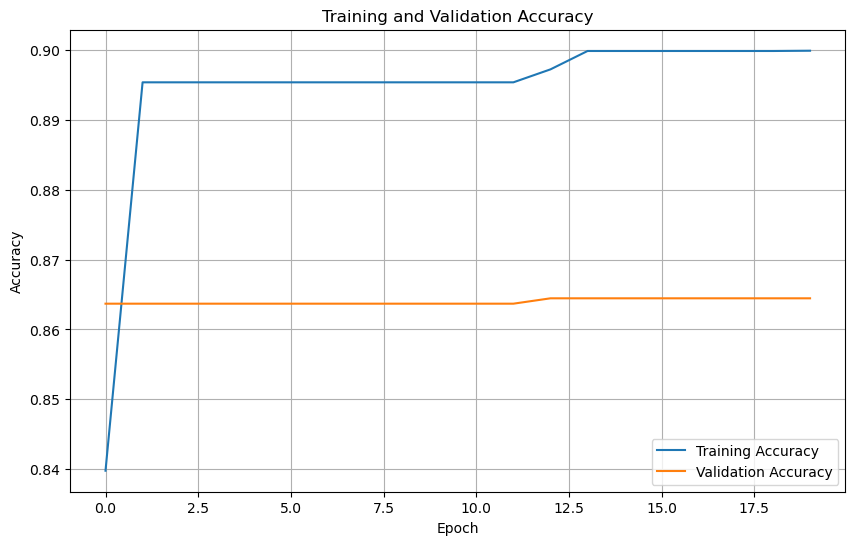

In [15]:
import matplotlib.pyplot as plt

# Train the model and capture the training history
#history = model.fit([X_train_padded, X_train_padded], y_train_padded, epochs=20, batch_size=32, validation_split=0.2)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


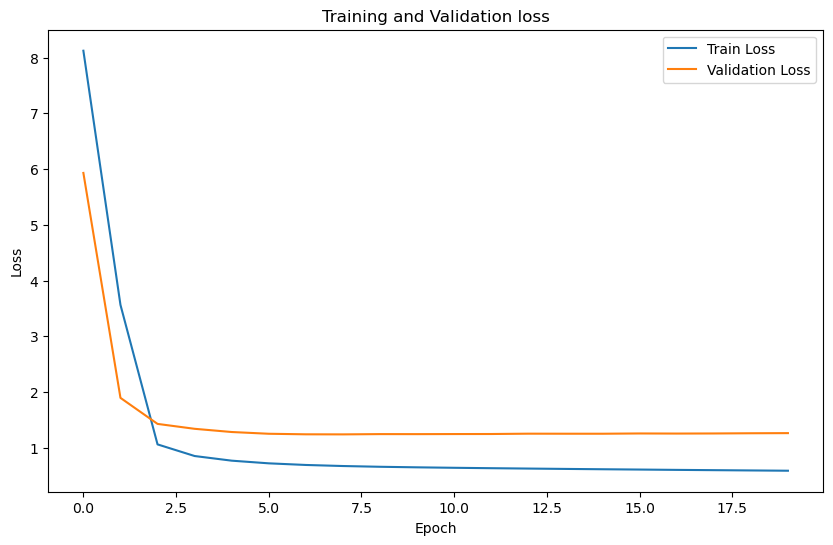

In [20]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
#plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()